# Training Pipeline for the Iris dataset

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
import hopsworks

# 1) Getting the Feature View

In [2]:
project = hopsworks.login()
fs = project.get_feature_store()

try: 
    feature_view = fs.get_feature_view(name="iris", version=1)

except:
    iris_fg = fs.get_feature_group(name="iris", version=1)
    query = iris_fg.select_all()
    feature_view = fs.create_feature_view(name="iris",
                                      version=1,
                                      description="Read from Iris flower dataset",
                                      labels=["variety"],
                                      query=query)

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/2266


Connected. Call `.close()` to terminate connection gracefully.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/2266/fs/2211/fv/iris/version/1


# 2) Splitting the train/test dataset

In [3]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

2022-10-01 23:01:23,783 INFO: USE `nahumsa_featurestore`
2022-10-01 23:01:24,862 INFO: SELECT `fg0`.`sepal_length` `sepal_length`, `fg0`.`sepal_width` `sepal_width`, `fg0`.`petal_length` `petal_length`, `fg0`.`petal_width` `petal_width`, `fg0`.`variety` `variety`
FROM `nahumsa_featurestore`.`iris_1` `fg0`


# 3) Training the model

In [5]:
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2)

# 4) Predicting the test dataset

In [6]:
y_pred = model.predict(X_test)
y_pred

array(['Versicolor', 'Virginica', 'Versicolor', 'Versicolor', 'Setosa',
       'Setosa', 'Setosa', 'Setosa', 'Versicolor', 'Versicolor', 'Setosa',
       'Versicolor', 'Versicolor', 'Versicolor', 'Virginica', 'Virginica',
       'Versicolor', 'Versicolor', 'Versicolor', 'Versicolor',
       'Versicolor', 'Versicolor', 'Setosa', 'Setosa', 'Versicolor',
       'Setosa', 'Setosa', 'Setosa', 'Versicolor', 'Versicolor'],
      dtype=object)

## 4.1) Classification report

In [7]:
from sklearn.metrics import classification_report

metrics = classification_report(y_test, y_pred, output_dict=True)
print(metrics)

{'Setosa': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10}, 'Versicolor': {'precision': 0.8823529411764706, 'recall': 1.0, 'f1-score': 0.9375, 'support': 15}, 'Virginica': {'precision': 1.0, 'recall': 0.6, 'f1-score': 0.7499999999999999, 'support': 5}, 'accuracy': 0.9333333333333333, 'macro avg': {'precision': 0.9607843137254902, 'recall': 0.8666666666666667, 'f1-score': 0.8958333333333334, 'support': 30}, 'weighted avg': {'precision': 0.9411764705882353, 'recall': 0.9333333333333333, 'f1-score': 0.9270833333333334, 'support': 30}}


## 4.2) Confusion Matrix

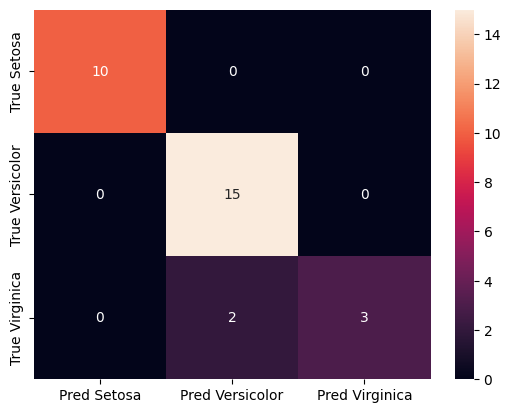

In [9]:
from sklearn.metrics import confusion_matrix

results = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(results,
                     ["True Setosa", "True Versicolor", "True Virginica"],
                     ["Pred Setosa", "Pred Versicolor", "Pred Virginica"],
                     )

fig = sns.heatmap(df_cm, annot=True);

In [12]:
fig = fig.get_figure()
fig.savefig("../../assets/confusion_matrix.png") 
fig.show()

# 5) Register the model to Hopsworks Model Registry

In [14]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import os
import joblib
import hopsworks
import shutil

mr = project.get_model_registry()

# The 'iris_model' directory will be saved to the model registry
model_dir="iris_model"

if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

joblib.dump(model, model_dir + "/iris_model.pkl")
shutil.copyfile("../../assets/confusion_matrix.png", model_dir + "/confusion_matrix.png")

input_example = X_train.sample()
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

iris_model = mr.python.create_model(
    version=1,
    name="iris", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    input_example=input_example, 
    description="Iris Flower Predictor")

iris_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/2266/models/iris/1


Model(name: 'iris', version: 1)